# Calculate mean CCT in non-root, non-leaf cells in 3 candidate cell trees:

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import sys
sys.path.append("../")
from Development.Movie_Analysis_Pipeline.Single_Movie_Processing.Server_Movies_Paths import Get_MDCK_Movies_Paths_Temporary


In [2]:
hdf5_file = "/Users/kristinaulicna/Documents/LIDo_PhD_Programme/Cells_MDCK/GV0800/pos12/HDF/segmented.hdf5"
cells = [14, 36, 33]

In [3]:
cct = [[] for _ in range(len(cells))]

with h5py.File(hdf5_file, "r") as f:
    for enum, (cell, progeny) in enumerate(zip(f["tracks"]["obj_type_1"]["LBEPR"], 
                                               f["tracks"]["obj_type_1"]["Ch_Ch_Gen_CCT"])):
        if cell[4] in cells:
            idx = cells.index(cell[4])
            
            if progeny[0] != 0 and progeny[1] != 0:
                cct[idx].append(float(progeny[3]))
        

In [4]:
for cell, item in zip(cells, cct):
    print (f"Tree ID #{cell} contains {len(item)} non-root, non-leaf cells\n\tMean = {round(np.mean(item), 2)} ± St.Dev = {round(np.std(item), 2)}")
           

Tree ID #14 contains 3 non-root, non-leaf cells
	Mean = 20.6 ± St.Dev = 6.52
Tree ID #36 contains 14 non-root, non-leaf cells
	Mean = 16.93 ± St.Dev = 4.49
Tree ID #33 contains 29 non-root, non-leaf cells
	Mean = 14.01 ± St.Dev = 1.86


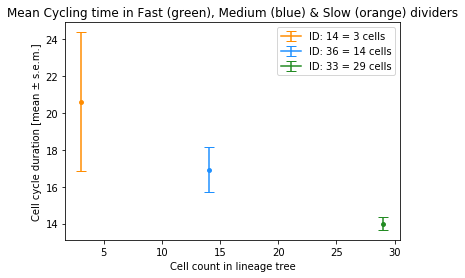

In [5]:
for cell, item, clr in zip(cells, cct, ["darkorange", "dodgerblue", "forestgreen"]):
    plt.errorbar(x=len(item), y=np.mean(item), yerr=np.std(item)/np.sqrt(len(item)), color=clr, capsize=5, label=f"ID: {cell} = {len(item)} cells")
    plt.scatter(x=len(item), y=np.mean(item), color=clr, s=15)

plt.title("Mean Cycling time in Fast (green), Medium (blue) & Slow (orange) dividers")
plt.xlabel("Cell count in lineage tree")
plt.ylabel("Cell cycle duration [mean ± s.e.m.]")
plt.legend()
plt.show()

## Analyse all 'full paths' from the tree pool in MDCK dataset:

-> **Go from leaves (at final frame) all the way backwards to their respective roots (at initial frame)**: 

Have a look at various branches e.g. in GV0800, pos 12, tree #33 would have exactly 29 full-duration paths from 29 leave cells to the same initial founder. 


# TODO: Calculate whether cycle-length is heritable:

Take generation #1 as mother & generation #2 as daughter in families where there are at least 2 cells in the path from beginning to the end of the movie:

+ Calculate whether there is a link between cell cycle times?
+ What is the distribution of cell cycle durations based on the path length? 
+ How many generations can you follow this trend for?

In [6]:
movies = Get_MDCK_Movies_Paths_Temporary()
cellC = [[] for _ in range(len(movies))]
unique_IDs = [[] for _ in range(len(movies))]

for enum, movie in enumerate(movies):
    hdf5_file = movie + "HDF/segmented.hdf5"
    pos, date = movie.split("/")[-2], movie.split("/")[-3]
    print (f"{date}, {pos}", end="\t")   
    
    with h5py.File(hdf5_file, "r") as f:
        movie_len = len(f["objects"]["obj_type_1"]["map"])
        ID_list = [item[0] for item in f["tracks"]["obj_type_1"]["LBEPR"]]
        leafs, roots = [], []

        for e, (cell, progeny) in enumerate(zip(f["tracks"]["obj_type_1"]["LBEPR"], 
                                                f["tracks"]["obj_type_1"]["Ch_Ch_Gen_CCT"])):
            
            if progeny[0] == 0 and progeny[1] == 0:
                if cell[2] == movie_len - 2:
                    if cell[3] != cell[4]:
                        leafs.append(cell[0])
                        roots.append(cell[4])

        for leaf in leafs:
            #print (f"Leaf = {leaf}")
            temporary = []
            
            leaf_index = ID_list.index(leaf)
            parent_ID = f["tracks"]["obj_type_1"]["LBEPR"][leaf_index][3]
            parent_index = ID_list.index(parent_ID)
            
            # Check if parent is valuable:
            while f["tracks"]["obj_type_1"]["LBEPR"][parent_index][4] != 0:
                #print (f["tracks"]["obj_type_1"]["LBEPR"][parent_index][0])
                temporary.append(f["tracks"]["obj_type_1"]["Ch_Ch_Gen_CCT"][parent_index][3])
                parent_index = ID_list.index(f["tracks"]["obj_type_1"]["LBEPR"][parent_index][3])
            
            # Now check whether your founder cell reaches to the very beginning of that movie:
            #print ("Data: {}".format(f["tracks"]["obj_type_1"]["LBEPR"][parent_index]))
            
            if f["tracks"]["obj_type_1"]["LBEPR"][parent_index][3] == 0:
                if f["tracks"]["obj_type_1"]["LBEPR"][parent_index][1] == 0:
                    cellC[enum].append(temporary)
                    
                    # Take a record of unique founder cell IDs (= trees) in your analysis:
                    unique_IDs[enum].append(f["tracks"]["obj_type_1"]["LBEPR"][parent_index][0])
                    
                    #print ("Appended")

    #break


AB0124, pos7	AB0124, pos8	AB0124, pos9	AB0327, pos0	AB0327, pos10	AB0327, pos2	AB0327, pos4	AB0327, pos6	AB0327, pos8	AB0724, pos0	AB0724, pos11	AB0724, pos13	AB0724, pos2	AB0724, pos4	AB0724, pos6	AB0724, pos7	AB0724, pos8	AB0724, pos9	AB0731, pos0	AB0731, pos1	AB0731, pos2	AB0731, pos3	AB0731, pos4	AB0731, pos5	AB0731, pos6	AB0731, pos7	AB0731, pos8	GV0794, pos11	GV0794, pos12	GV0795, pos0	GV0795, pos11	GV0795, pos12	GV0795, pos13	GV0796, pos11	GV0796, pos12	GV0796, pos13	GV0796, pos14	GV0798, pos0	GV0798, pos11	GV0798, pos12	GV0798, pos13	GV0800, pos0	GV0800, pos11	GV0800, pos12	

In [7]:
counter, counter_unique = 0, 0

for movie in unique_IDs:
    #print (movie)
    print ("Total paths: {} -> out of which unique root IDs: {}".format(len(movie), len(set(movie))))
    counter += len(movie)
    counter_unique += len(set(movie))
    
print (counter, counter_unique, counter_unique*100/counter)

Total paths: 34 -> out of which unique root IDs: 10
Total paths: 38 -> out of which unique root IDs: 19
Total paths: 42 -> out of which unique root IDs: 19
Total paths: 262 -> out of which unique root IDs: 54
Total paths: 280 -> out of which unique root IDs: 64
Total paths: 337 -> out of which unique root IDs: 70
Total paths: 286 -> out of which unique root IDs: 71
Total paths: 179 -> out of which unique root IDs: 34
Total paths: 310 -> out of which unique root IDs: 50
Total paths: 121 -> out of which unique root IDs: 38
Total paths: 141 -> out of which unique root IDs: 33
Total paths: 0 -> out of which unique root IDs: 0
Total paths: 76 -> out of which unique root IDs: 14
Total paths: 154 -> out of which unique root IDs: 46
Total paths: 50 -> out of which unique root IDs: 11
Total paths: 46 -> out of which unique root IDs: 5
Total paths: 13 -> out of which unique root IDs: 3
Total paths: 159 -> out of which unique root IDs: 34
Total paths: 269 -> out of which unique root IDs: 57
Total

### Sort data based on progeny size:

In [8]:
# The paths you want to analyse have different lengths, including 2 (slowest), 3, 4, 5, 6, and 7 intermediate cells: 
hist_data = [[[] for _ in range(e+1)] for e, _ in enumerate(range(7))]

for movie in cellC:
    for path in movie: 
        # Exclude paths which only have 'root - leaf' or 'root - cell - leaf' trajectories:
        if len(path) > 0:
            for e, item in enumerate(path[::-1]):
                hist_data[len(path)-1][e].append(item)


### Plot the histograms of divider subpopulations with ranging cycling speeds

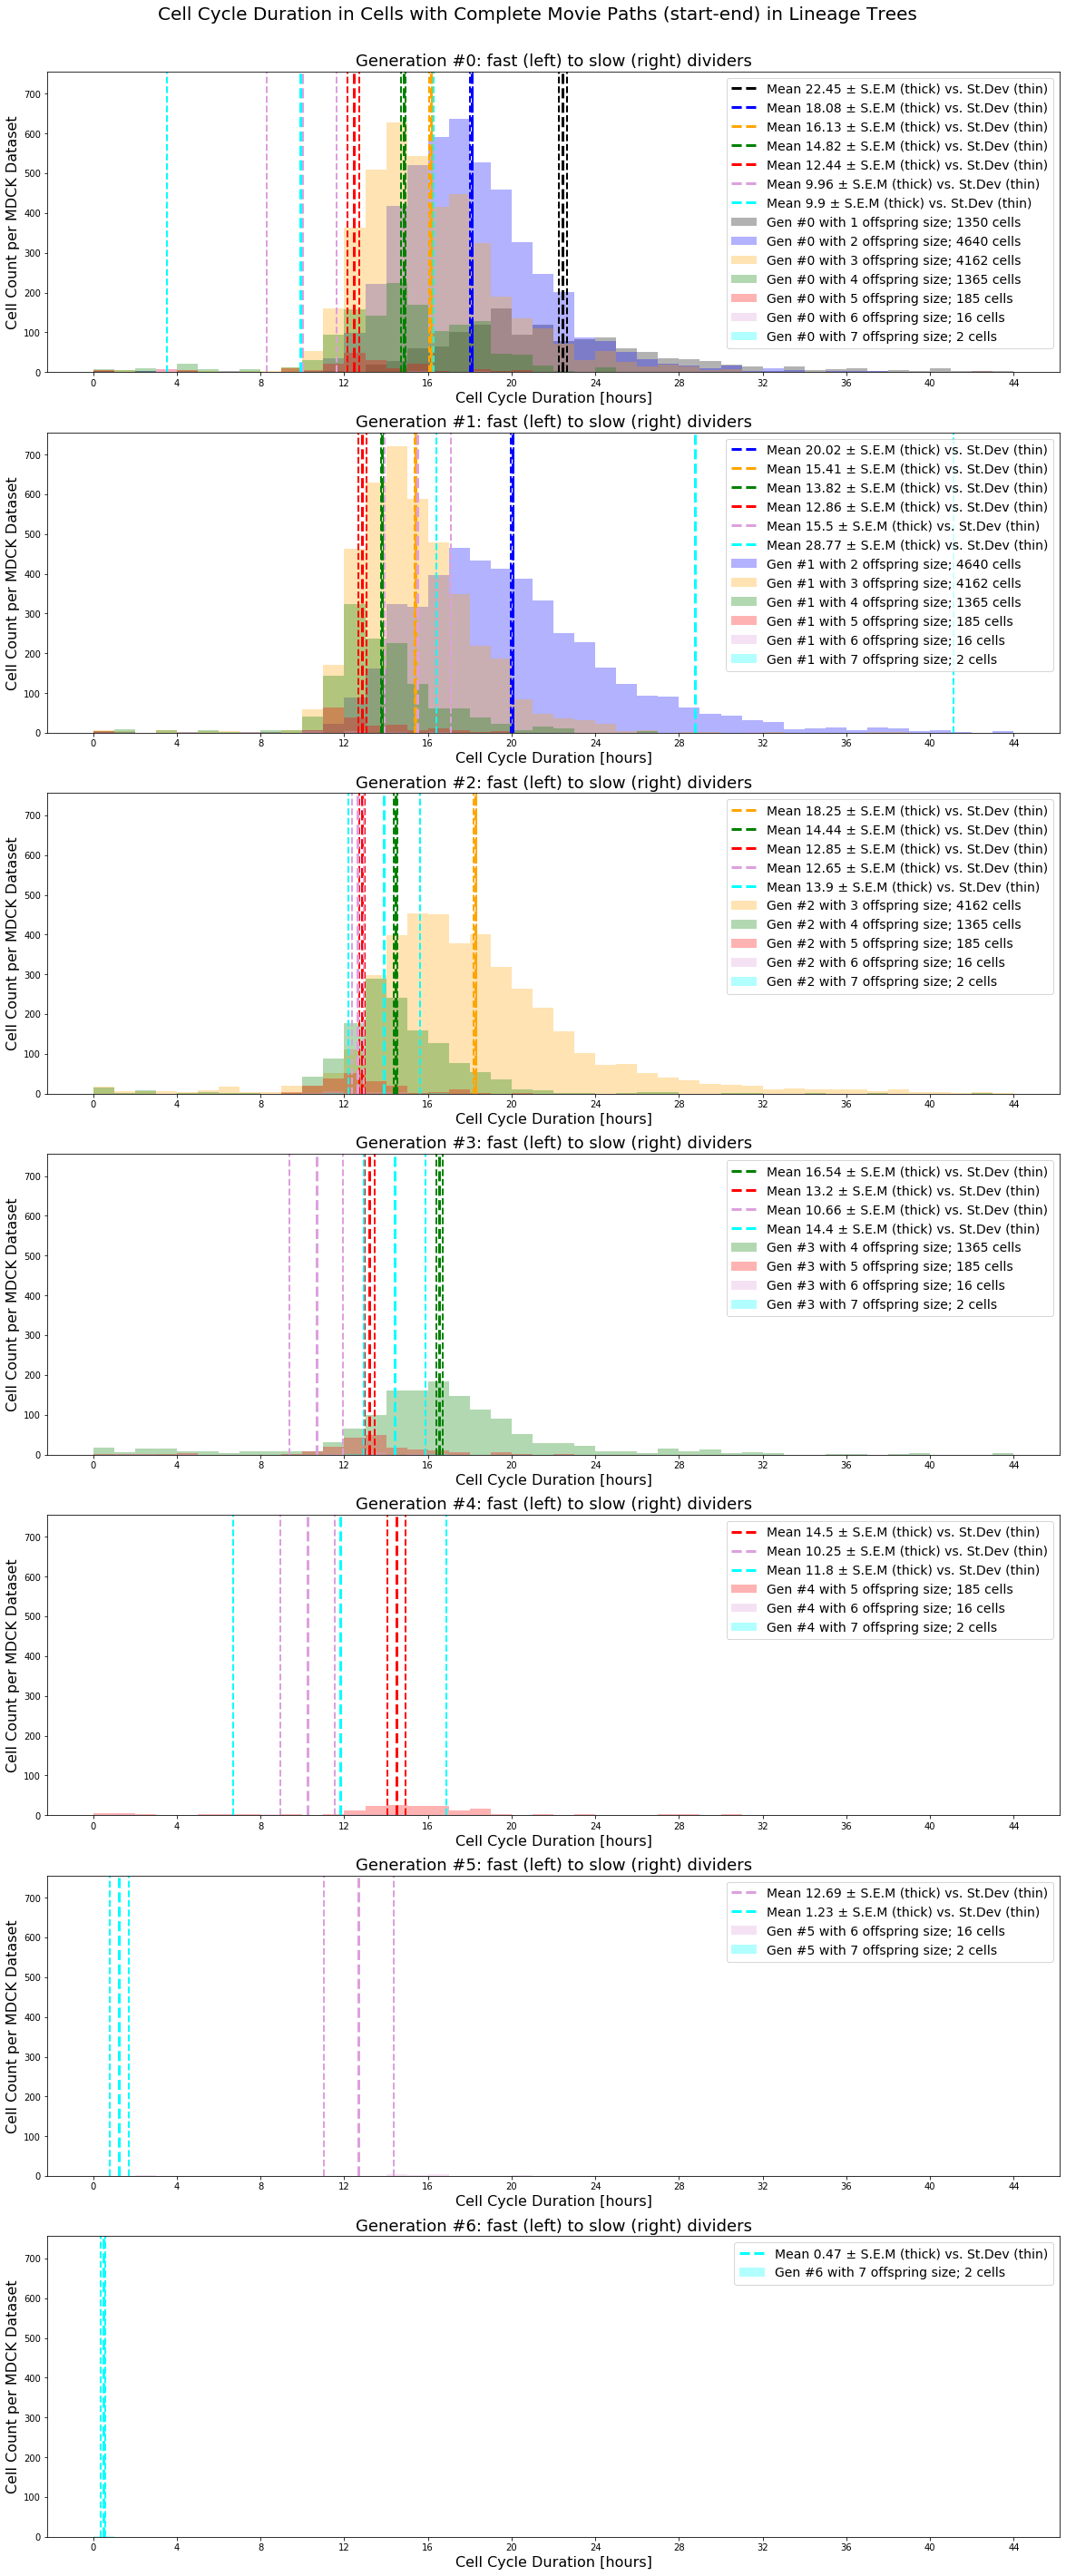

In [9]:
fig, axs = plt.subplots(nrows=len(hist_data), ncols=1, sharey=True, figsize=(20, 50))
fig.suptitle(t="Cell Cycle Duration in Cells with Complete Movie Paths (start-end) in Lineage Trees", x=0.5, y=0.9, fontsize=20)
colours = ["black", "blue", "orange", "green", "red", "plum", "cyan"]

for enum, path in enumerate(hist_data):
    
    for index in range(len(path)):
    
        axs[index].hist(path[index], bins=44, range=(0, 44), alpha=0.3, color=colours[enum], label=f"Gen #{index} with {enum+1} offspring size; {len(path[index])} cells")
        axs[index].axvline(x=np.mean(path[index]), color=colours[enum], linestyle="dashed", linewidth=3, label=f"Mean {round(np.mean(path[index]), 2)} ± S.E.M (thick) vs. St.Dev (thin)")
        axs[index].axvline(x=np.mean(path[index])-(np.std(path[index])/np.sqrt(len(path[index]))), color=colours[enum], linestyle="dashed", linewidth=2)
        axs[index].axvline(x=np.mean(path[index])+(np.std(path[index])/np.sqrt(len(path[index]))), color=colours[enum], linestyle="dashed", linewidth=2)
        
        axs[index].set_title(f"Generation #{index}: fast (left) to slow (right) dividers", fontsize=18)
        axs[index].set_ylabel("Cell Count per MDCK Dataset", fontsize=16)
        axs[index].set_xlabel("Cell Cycle Duration [hours]", fontsize=16)
        axs[index].set_xticks(list(range(0, 45, 4)))
        axs[index].legend(loc="upper right", fontsize=14)

plt.show()


### Plot the final results - generational means ± s.e.m & drifts!

Gen #1 mean = 22.45 -> whole movie duration estimate = 67.0
Gen #1 mean = 18.08 -> whole movie duration estimate = 72.0
Gen #1 mean = 16.13 -> whole movie duration estimate = 81.0
Gen #1 mean = 14.82 -> whole movie duration estimate = 89.0
Gen #1 mean = 12.44 -> whole movie duration estimate = 87.0


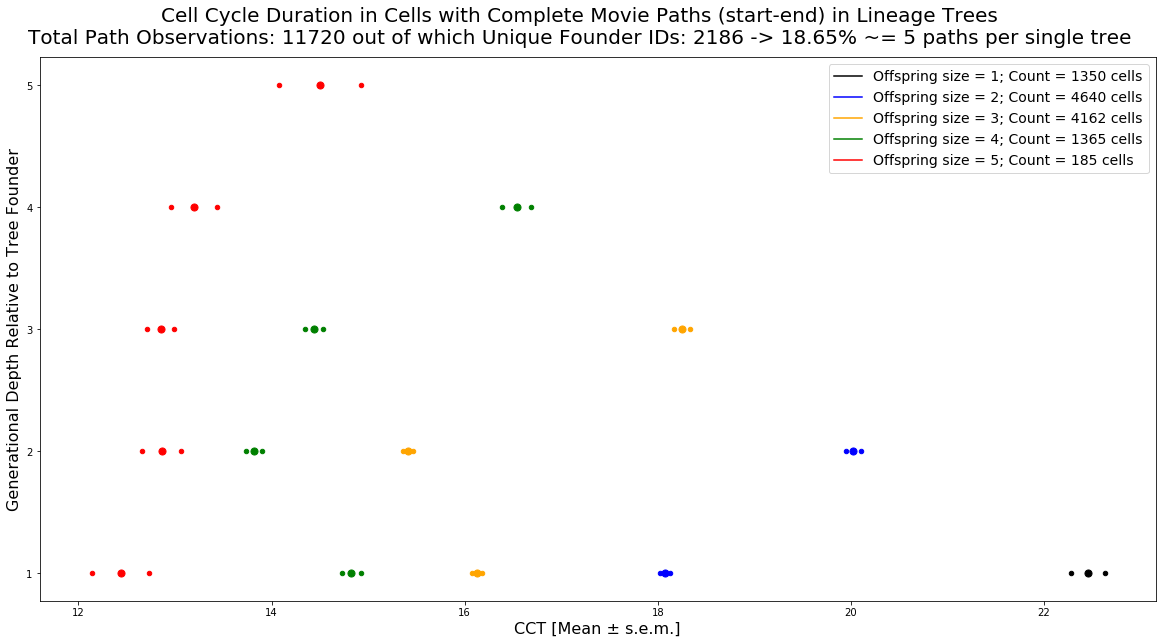

In [10]:
fig, axs = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(20, 10))
fig.suptitle(t=f"Cell Cycle Duration in Cells with Complete Movie Paths (start-end) in Lineage Trees"
               f"\nTotal Path Observations: {counter} out of which Unique Founder IDs: {counter_unique} "
               f"-> {round(counter_unique*100/counter, 2)}% ~= 5 paths per single tree", x=0.5, y=0.95, fontsize=20)
colours = ["black", "blue", "orange", "green", "red", "plum", "cyan"]

mean_data = [[[] for _ in range(e+1)] for e, _ in enumerate(range(7))]

for enum, path in enumerate(hist_data[:-2]):
    
    for index in range(len(path)):
    
        mean = np.mean(path[index])
        sem = np.std(path[index]) / np.sqrt(len(path[index]))
        
        if index == 0:
            print ("Gen #1 mean = {} -> whole movie duration estimate = {}".format(round(mean, 2), round(mean * (enum + 3))))
            plt.plot([], [], color=colours[enum], label=f"Offspring size = {enum + 1}; Count = {len(path[index])} cells")
        
        plt.scatter(x=mean, y=index+1, s=50, color=colours[enum])
        plt.scatter(x=mean+sem, y=index+1, s=20, color=colours[enum])
        plt.scatter(x=mean-sem, y=index+1, s=20, color=colours[enum])
        
        plt.xlabel("CCT [Mean ± s.e.m.]", fontsize=16)
        plt.ylabel("Generational Depth Relative to Tree Founder", fontsize=16)
        plt.yticks(list(range(1, len(hist_data[:-2]) + 1)))
        plt.legend(loc="upper right", fontsize=14)
        
plt.show()
plt.close()


### Re-plot with error bars & shading appropriate for publication:

In [11]:
save_dr = "/Users/kristinaulicna/Documents/LIDo_PhD_Programme/Cells_MDCK/overall_analysis/Figure_2_Three_Candidates/cell_cycle_graphs/"


Gen #1 mean = 22.45 -> whole movie duration estimate = 67.0
Gen #1 mean = 18.08 -> whole movie duration estimate = 72.0
Gen #1 mean = 16.13 -> whole movie duration estimate = 81.0
Gen #1 mean = 14.82 -> whole movie duration estimate = 89.0
Gen #1 mean = 12.44 -> whole movie duration estimate = 87.0


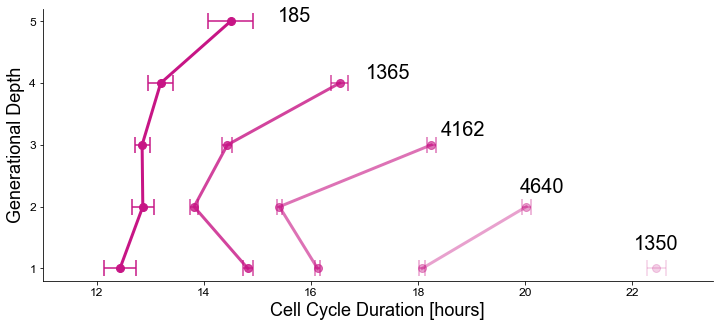

In [14]:
_ = plt.subplots(figsize=(12, 5))
mean_data = [[[] for _ in range(e+1)] for e, _ in enumerate(range(7))]

for enum, path in enumerate(hist_data[:-2]):
    
    for index in range(len(path)):
        
        mean = np.mean(path[index])
        sem = np.std(path[index]) / np.sqrt(len(path[index]))
        
        mean_data[len(path)-1][index].append([mean, sem])
        
        if index == 0:
            print ("Gen #1 mean = {} -> whole movie duration estimate = {}".format(round(mean, 2), round(mean * (enum + 3))))
            
        plt.errorbar(x=mean, y=index+1, xerr=sem, color="mediumvioletred", alpha=(enum+1)*0.2,
                     ecolor="mediumvioletred", elinewidth=1.5, capsize=8, capthick=1.5)
        plt.xlabel("Cell Cycle Duration [hours]", fontname="Arial", fontsize=18)
        plt.ylabel("Generational Depth", fontname="Arial", fontsize=18)
        plt.yticks(list(range(1, len(hist_data[:-2]) + 1)), fontname="Arial", fontsize=12)
        plt.xticks(fontname="Arial", fontsize=12)
        plt.xlim(11, 23.5)

        if index == len(path) - 1:
            plt.text(x=mean+enum*0.3, y=index+1 + 0.4 - enum*0.08, s=str(len(path[index])), 
                     fontname="Arial", fontsize=20, horizontalalignment='center', verticalalignment='center')
            
for eee, offspring_len in enumerate(mean_data[:-2]):
    plt.plot([item[0][0] for item in offspring_len], range(1, len([item[0][0] for item in offspring_len]) + 1), 
             marker='o', markersize=8, color="mediumvioletred", alpha=(eee+1)*0.2, linewidth=3.0, linestyle="solid", label=eee + 1)
    
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

plt.savefig(save_dr + "cycling_heritability.pdf", bbox_to_inches="tight", transparent=True)
plt.show()


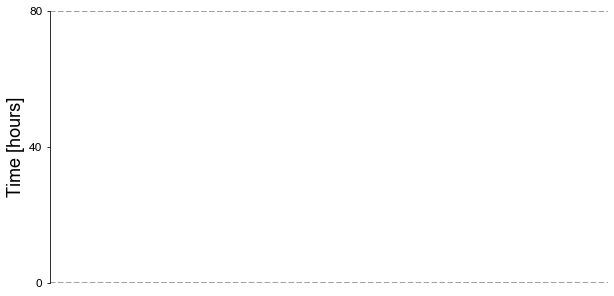

In [20]:
_ = plt.subplots(figsize=(10, 5))

plt.ylabel("Time [hours]", fontname="Arial", fontsize=18)
plt.yticks(range(0, 80+1, 40), fontname="Arial", fontsize=12)
plt.xticks([])
plt.axhline(y=0, linestyle="dashed", color="grey")
plt.axhline(y=80, linestyle="dashed", color="grey")

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = False

plt.savefig(save_dr + "path_sketch_axis.pdf", bbox_to_inches="tight", transparent=True)
plt.show()